In [79]:
import numpy as np
from pcgym import make_env


The environment used in the this problem is a Continuously Stirred Tank Reactor (CSTR) performing an exothermic reaction (A → B). The controlled variable with be the concentration of species A by manipulating the temperature of the cooling jacket. A diagram of the environment is given below.

<div style="text-align:center">
  <img src="..\docs\img\CSTR_PFD.png" alt="CSTR" width="400">
</div>


In [82]:
T = 26
nsteps = 60

SP = {
    'Ca': [0.85 for i in range(int(nsteps/3))] + 
          [0.9 for i in range(int(nsteps/3))] + 
          [0.87 for i in range(int(nsteps/3))],
}

action_space = {
    'low': np.array([295]),
    'high': np.array([302])
}

observation_space = {
    'low': np.array([0.7, 300, 0.8]),
    'high': np.array([1, 350, 0.9])
}

r_scale = {'Ca': 1e3}

env_params = {
    'N': nsteps,
    'tsim': T,
    'SP': SP,
    'o_space': observation_space,
    'a_space': action_space,
    'x0': np.array([0.8, 330, 0.8]),
    'r_scale': r_scale,
    'model': 'cstr',
    'normalise_a': True,
    'normalise_o': True,
    'noise': True,
    'integration_method': 'casadi',
    'noise_percentage': 0.001,
}
env = make_env(env_params)

We can display the current setup of the model with the following

In [77]:
env.model.info()

{'parameters': {'q': 100,
  'V': 100,
  'rho': 1000,
  'C': 0.239,
  'deltaHr': -50000.0,
  'EA_over_R': 8750,
  'k0': 72000000000.0,
  'UA': 50000.0,
  'Ti': 350,
  'Caf': 1,
  'states': ['Ca', 'T'],
  'inputs': ['Tc'],
  'disturbances': ['Ti', 'Caf'],
  'uncertainties': None},
 'states': ['Ca', 'T'],
 'inputs': ['Tc'],
 'disturbances': ['Ti', 'Caf'],
 'uncertainties': []}

### P, PI, and PID Controllers

Here we implement a P, PI and PID controller to show the interaction between policy and environment.


#### P Controller
The Proportional (P) controller adjusts the control input $(u(t))$ proportionally to the error $(e(t))$. The mathematical definition is:
$$ u(t) = K_p \cdot e(t) $$
where:
- $(u(t))$ is the control input.
- $(K_p)$ is the proportional gain.
- $(e(t) = SP - PV)$ is the error, with $(SP)$ being the setpoint and $(PV)$ being the process variable.

In [47]:
class p_controller:
    def predict(o, deterministic = False):
        sp = o[2]
        x = o[0]
        e = sp - x
        kp = -2
        u = kp*e
        return u, 0

#### PI Controller
The Proportional-Integral (PI) controller adjusts the control input $(u(t))$ based on the proportional and integral of the error. The mathematical definition is:
$$ u(t) = K_p \cdot e(t) + K_i \cdot \int_0^t e(\tau) d\tau $$
where:
- $(K_p)$ is the proportional gain.
- $(K_i)$ is the integral gain.
- $\int_0^t e(\tau) d\tau$ is the integral of the error over time.


In [49]:
class pi_controller:
  integral = 0

  @staticmethod
  def predict(o, deterministic=False):
    sp = o[2]
    x = o[0]
    e = sp - x
    kp = -2
    ki = -1
    pi_controller.integral += e
    u = kp * e + ki * pi_controller.integral
    return u, 0

#### PID Controller
The Proportional-Integral-Derivative (PID) controller adjusts the control input $(u(t))$ based on the proportional, integral, and derivative of the error. The mathematical definition is:
$$ u(t) = K_p \cdot e(t) + K_i \cdot \int_0^t e(\tau) d\tau + K_d \cdot \frac{de(t)}{dt} $$
where:
- $(K_p)$ is the proportional gain.
- $(K_i)$ is the integral gain.
- $(K_d)$ is the derivative gain.
- $\frac{de(t)}{dt}$ is the derivative of the error with respect to time.

In [69]:
class pid_controller:
  integral = 0
  previous_error = 0

  @staticmethod
  def predict(o, deterministic=False):
    sp = o[2]
    x = o[0]
    e = sp - x
    kp = -1
    ki = -1.5
    kd = -0.05
    pid_controller.integral += e
    derivative = e - pid_controller.previous_error
    u = kp * e + ki * pid_controller.integral + kd * derivative
    pid_controller.previous_error = e
    return u, 0

Then we can plot all three controllers as follows with the oracle:

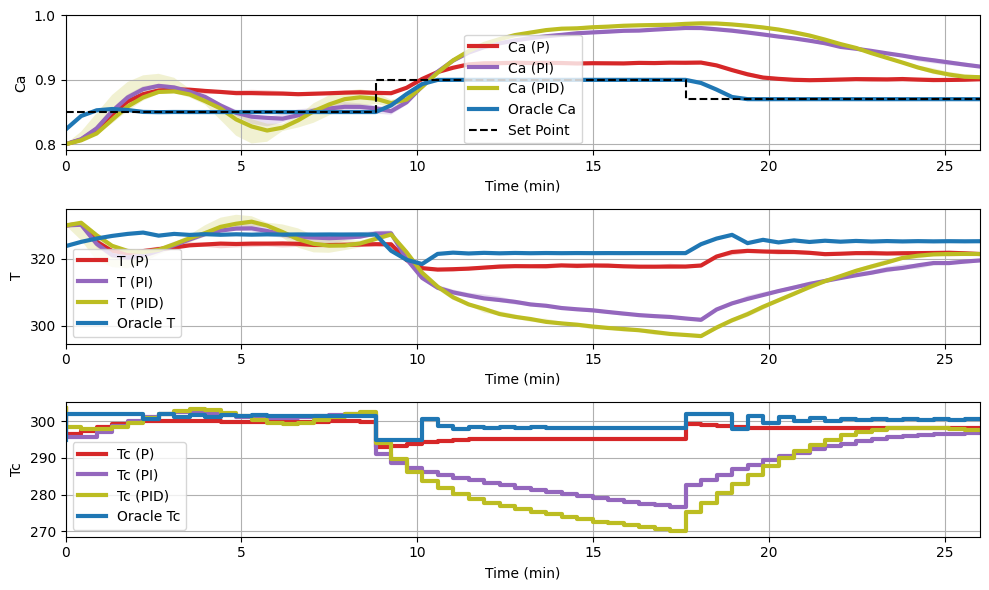

In [83]:
evaluator, data = env.plot_rollout({'P': p_controller, 'PI':pi_controller, 'PID':pid_controller}, reps=10, oracle=True)

Looks like the controllers need some tuning!